In [2]:
import pandas as pd
import geopandas as gpd
import requests, json
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Loading and reading files
AAnn = pd.read_csv('Austin_Annual_Crime_Dataset_2015.csv')
AUF2015= pd.read_csv("Austin_UF_R2R_2015.csv")
#sf = pd.read_csv("stackfinal.csv")
districts = gpd.read_file("Single Member Council Districts.geojson")

In [4]:
#Renaming columns
AUF2015.rename(columns={' Primary Key': 'Key', ' Effect on Officer': ' OfficerEffects', 'Nature of Contact':'NatureOfContact', 'Officer Yrs of Service': 'OfficerYrsServ'}, inplace=True)
AAnn.rename(columns={'HighestNIBRS/UCROffenseDescription':'NIBRS', 'Council District': 'Council_District'}, inplace=True)

#Removing spaces in column names
AUF2015.columns = AUF2015.columns.str.replace('\s+','')
AAnn.columns = AAnn.columns.str.replace('\s+','')

#Dropping duplicates from AUF2015 set. Only AUF2015 has duplicates.
AUF2015 = AUF2015.drop_duplicates(subset='Key', keep='first', inplace = False)

# Map of overall crime

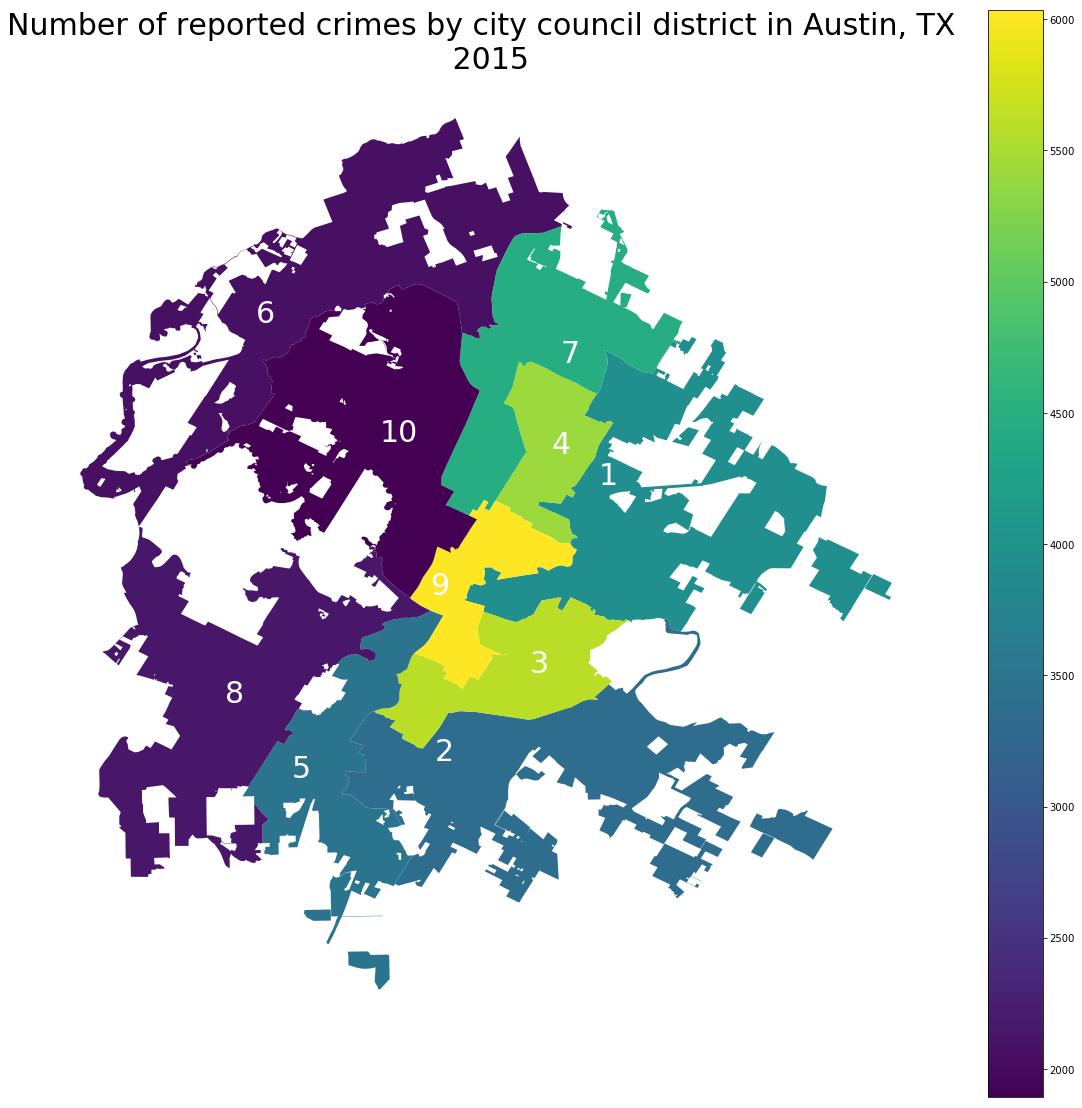

In [5]:
#Group by district and counting crime incidents
AAnnCount = AAnn.groupby('Council_District').count()

#Convert index to interger and reset index of districts so can merge with count data.
AAnnCount.index = AAnnCount.index.map(lambda x: int(x))

districts.set_index(districts['council_di'].astype(int), inplace = True)
districts.index = districts.index.map(lambda x: int(x))

# Merging districts with crime counts data
geo_merge = pd.merge(districts, pd.DataFrame(AAnnCount.loc[:, 'GOPrimaryKey']).rename(columns = {'GOPrimaryKey': 'count'}), left_index = True, right_index = True, how = 'outer' )

# Map of overall crime
AAnnMap = geo_merge.plot(column = "count",legend = True, cmap = 'viridis' , linewidth = 0, figsize = (20,20))

# Label each district
geo_merge['coords'] = geo_merge['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_merge['coords'] = [coords[0] for coords in geo_merge['coords']]

for idx, row in geo_merge.iterrows():
    AAnnMap.annotate(s = row['single_mem'], xy = row['coords'], horizontalalignment= 'center', fontsize = 30, color = 'white')

AAnnMap.set_title('Number of reported crimes by city council district in Austin, TX \n 2015', fontsize = 30, loc = 'center')
AAnnMap.set_axis_off()

AAnnMap.figure.savefig('AAnnMap.png')

# Map of Use of Force (UF) reports

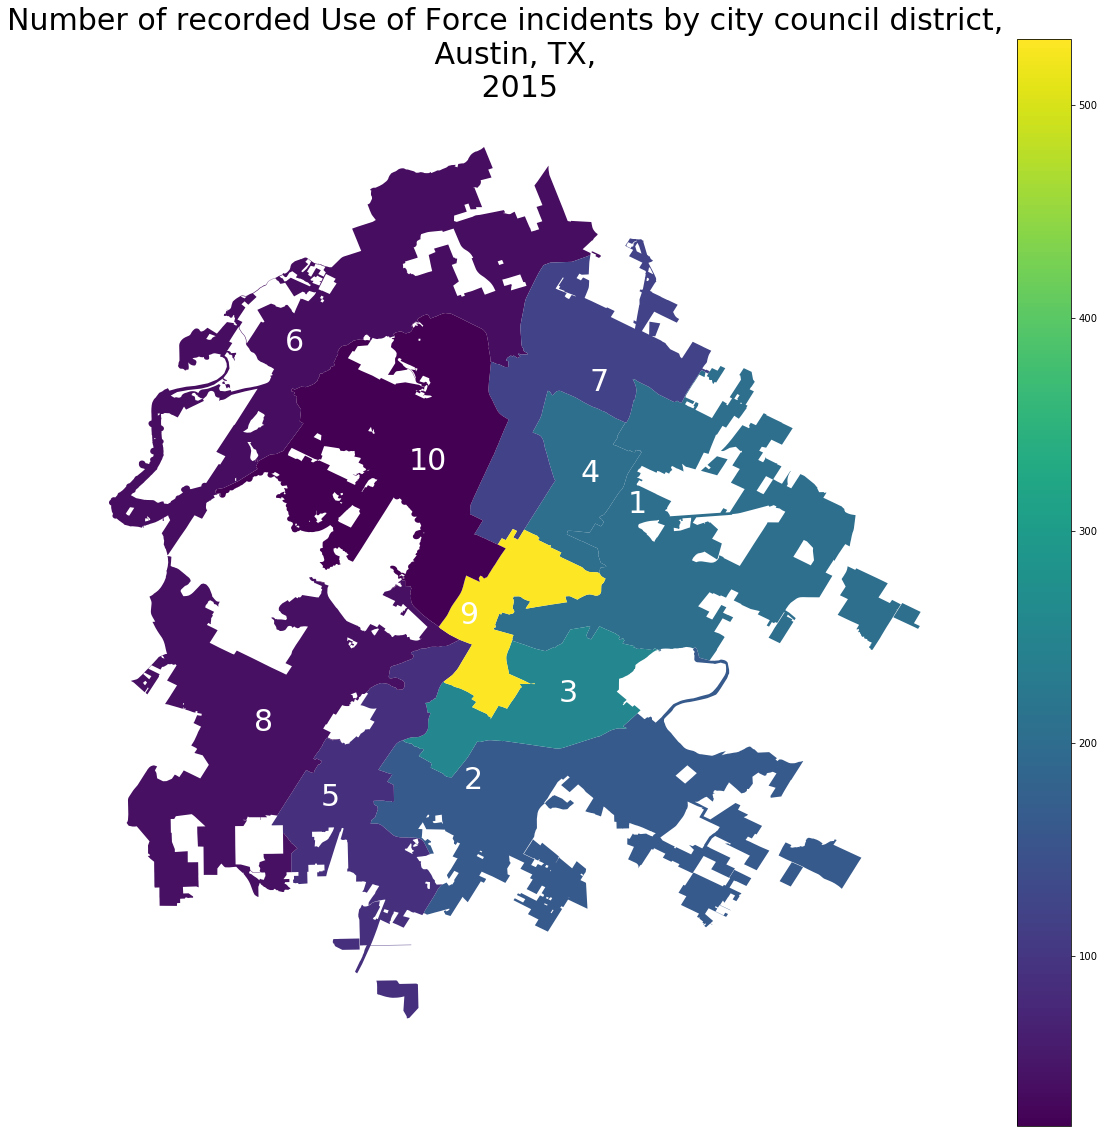

In [6]:
#Group by district and counting UF incidents
AUF2015Count = AUF2015.groupby('CouncilDistrict').count()

#Convert index to interger so can merge with districts
AUF2015Count.index = AUF2015Count.index.map(lambda x: int(x))

# Merging districts with AUF2015 (UF counts)
AUF_merge = pd.merge(districts, pd.DataFrame(AUF2015Count.loc[:, 'RIN']).rename(columns = {'RIN': 'count'}), left_index = True, right_index = True, how = 'outer')

# Map of UF crime
AUFMap = AUF_merge.plot(column = "count", legend = True, cmap = 'viridis' , linewidth = 0, figsize = (20,20))

# Label each district
AUF_merge['coords'] = AUF_merge['geometry'].apply(lambda x: x.representative_point().coords[:])
AUF_merge['coords'] = [coords[0] for coords in AUF_merge['coords']]

for idx, row in AUF_merge.iterrows():
    AUFMap.annotate(s = row['single_mem'], xy = row['coords'], horizontalalignment= 'center', fontsize = 30, color = 'white')

AUFMap.set_title('Number of recorded Use of Force incidents by city council district,  \n Austin, TX, \n 2015', fontsize = 30, loc = 'center')
AUFMap.set_axis_off()

AUFMap.figure.savefig('AUFMap.png')

## Number of use of crimes by city council district

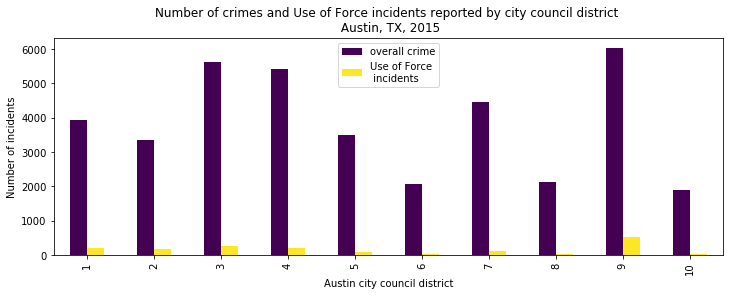

In [7]:
#Merging counts of UF and 
bigmerge = pd.merge(geo_merge, pd.DataFrame(AUF_merge.loc[:,'count'].rename(columns = {'count': 'AUFcount'})),\
left_index = True, right_index = True, how = 'outer')
bigmerge = bigmerge.rename(columns={bigmerge.columns[11]: "AUFcount"})

AAnnAUFPlot = bigmerge[['count','AUFcount']].plot(kind = "bar", colormap = "viridis", figsize = (12, 4))

AAnnAUFPlot.legend(['overall crime', 'Use of Force \n incidents'], loc = 'upper center')
AAnnAUFPlot.set_title("Number of crimes and Use of Force incidents reported by city council district \n Austin, TX, 2015", fontsize = 12, y = 1)
AAnnAUFPlot.set_xlabel('Austin city council district')
AAnnAUFPlot.set_ylabel('Number of incidents')

AAnnAUFPlot.figure.savefig('AAnnAUFPlot.png')
